## Libraries

Libraries to be used in this notebook:
* `util.py`: A custom .py file to extract images and bounding box information from BCCD dataset
* `matplotlib` and `PIL` to plot images
* `imgaug`: To perform image augmentation and also to compute bounding boxes for images after augmentation
* Other miscllenaous libraries

In [35]:
import util

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import imageio as io

import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmenters.meta import Sometimes
from imgaug.augmentables.bbs import BoundingBoxesOnImage

import numpy as np
import pandas as pd

import glob
import os
import shutil
from google.colab import files

In [ ]:
# Extract data from zip file
!unzip '/content/BCCD_New.zip'

In [98]:
!rm -rf '/content/YOLO'


Load the BCCD data into the notebook.

## Training / Validation / Test

Split the dataset in training validation ans test. Store the images in respective folders and zip them before downloading.

 Create following folder structure:  
 - YOLO
  - Training
    - Images
    - Annotations
    - Aug1
      - Images
    - Aug2
      - Images
  - Test
    - Images
    - Annotations
  - Validation
    - Images
    - Annotations

The training/ test / validation data will be stored in this order.

'YOLO/Training/Aug1' and ''YOLO/Training/Aug2' will be used to save augmented images.

In [107]:

# Sort the paths obtained from os.listdir to ensure same file order in images and annotations
images = sorted(os.listdir('/content/JPEGImages'))
annotations = sorted(os.listdir('/content/Annotations'))

# Maintain seed to generate same random number for image files and annotation files
np.random.seed(2022)
for f in images:
  num= np.random.rand(1)
  if num < 0.85:
    shutil.copy('/content/JPEGImages' + '/' + f, '/content/YOLO/Training/Images' + '/' + f)
  elif 0.85 < num < 0.9 :
    shutil.copy('/content/JPEGImages' + '/' + f, '/content/YOLO/Validation/Images' + '/' + f)
  else:
    shutil.copy('/content/JPEGImages' + '/' + f, '/content/YOLO/Test/Images' + '/' + f)

np.random.seed(2022)
for f in annotations:
  num= np.random.rand(1)
  if num < 0.85:
    shutil.copy('/content/Annotations' + '/' + f, '/content/YOLO/Training/Annotations' + '/' + f)
  elif 0.85 < num < 0.9 :
    shutil.copy('/content/Annotations' + '/' + f, '/content/YOLO/Validation/Annotations' + '/' + f)
  else:
    shutil.copy('/content/Annotations' + '/' + f, '/content/YOLO/Test/Annotations' + '/' + f)

In [108]:
print('Number of images in training directory: ', len(glob.glob('/content/YOLO/Training/Images/*jpg')))
print('Number of images in validation directory: ', len(glob.glob('/content/YOLO/Validation/Images/*jpg')))
print('Number of images in test directory: ', len(glob.glob('/content/YOLO/Test/Images/*jpg')))

Number of images in training directory:  298
Number of images in validation directory:  21
Number of images in test directory:  45


Lst's take a look at training data

In [112]:
# store annotations in a data frame
BCCDdf,_= util.load_data(annotation_path='/content/YOLO/Training/Annotations')

In [113]:
BCCDdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6041 entries, 1632 to 884
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         6041 non-null   int64 
 1   filename   6041 non-null   object
 2   cell_type  6041 non-null   object
 3   xmin       6041 non-null   int64 
 4   xmax       6041 non-null   int64 
 5   ymin       6041 non-null   int64 
 6   ymax       6041 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 377.6+ KB


In [114]:
BCCDdf.head()

,ID,filename,cell_type,xmin,xmax,ymin,ymax
1632,0,/content/YOLO/Training/Annotations/BloodImage_...,RBC,375,455,108,194
1612,0,/content/YOLO/Training/Annotations/BloodImage_...,WBC,268,489,196,365
1613,0,/content/YOLO/Training/Annotations/BloodImage_...,RBC,221,323,369,460
1614,0,/content/YOLO/Training/Annotations/BloodImage_...,RBC,88,165,333,432
1615,0,/content/YOLO/Training/Annotations/BloodImage_...,RBC,4,95,364,479


# Augmentation
Image augmentation is a technique to generate synthetic images from existing ones. This would help us to increse the dataset and also to learn robust pattern in the images.  
Some image augmentation techniques does not change the relative position of the objects in the image (e.g. adjust brightness, add Gaussian noise etc.). However, techniques like rotation, flip etc. can change the location of the object in the image. Especially, the later one is tricky for object detection challanges. Such augmentation also changes the lateral position of the bounding boxes. Therefore, the bounding box co-ordinates are requires to be re calculated.

## Image augmentation pipeline
At first we experiment the following augmentation techniques:  
- Brightness : Allow to learn about light sensitivity, we consider  +/- 20% brightness adjustment.
- Salt pepper noise: Degrade the quality of the image by infusing salt pepper noise to 5% of the pixels.
- Crop: Allow 0-20% zoom
- Flip: Horizental and vertical flip.
- Rotation: Rotate the image =/- 10 degree

The first two augmentation techniques do not change the location of the objects. However the next three change the bounding box location.

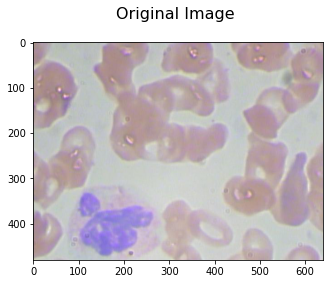

In [124]:
im= Image.open('/content/YOLO/Training/Images/BloodImage_001.jpg')
plt.imshow(im)
plt.title('Original Image \n', size=16)
plt.show()

In [116]:
# Horizental flip with prob. 100%
FlipH = iaa.Sequential(iaa.Fliplr(1))
# Vertical flip with prob. 100%
FlipV = iaa.Sequential(iaa.Flipud(1))
# Salt pepper noise to 5% of the pixels
SPnoise = iaa.Sequential(iaa.SaltAndPepper(0.05))
# Adjust brightness by multiplying each pixel by a values between (0.75, 1.25)
Brgtness = iaa.Multiply((0.75,1.25),per_channel=True)
# Rotate to +/- 10 degrees
Rotate= iaa.Affine(rotate=(-10,10))
# Crop or zoom by 20% in both axes
RCrop = iaa.Affine(scale={"x": (1,1.2),"y": (1,1.2)})

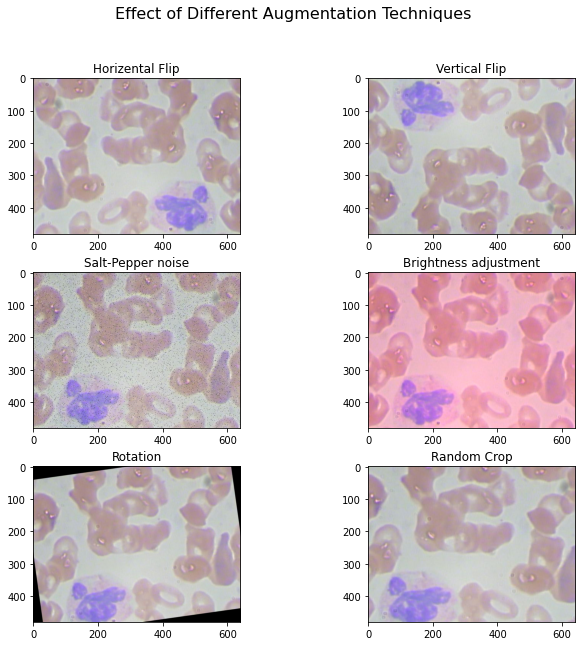

In [117]:
from IPython.core.pylabtools import figsize
fig, axs = plt.subplots(3,2, figsize=(12,10))
plt.subplots_adjust(hspace=0.25, wspace=0)
fig.suptitle('Effect of Different Augmentation Techniques',size=16)
axs[0,0].imshow(Image.fromarray(FlipH(image=np.array(im))))
axs[0,0].set_title('Horizental Flip')
axs[0,1].imshow(Image.fromarray(FlipV(image=np.array(im))))
axs[0,1].set_title('Vertical Flip')
axs[1,0].imshow(Image.fromarray(SPnoise(image=np.array(im))))
axs[1,0].set_title('Salt-Pepper noise')
axs[1,1].imshow(Image.fromarray(Brgtness(image=np.array(im))))
axs[1,1].set_title('Brightness adjustment')
axs[2,0].imshow(Image.fromarray(Rotate(image=np.array(im))))
axs[2,0].set_title('Rotation')
axs[2,1].imshow(Image.fromarray(RCrop(image=np.array(im))))
axs[2,1].set_title('Random Crop')
plt.show()

For final augmentation pipeline , we can perform any of these augmentation alone or we can combine them together. We allow upto 2 augmentations per images to avoid unnecessary degredation of the true images.  
The following representation creates a pipeline of different augmentation techniques but allowing upto 2 per image. 

In [119]:
# Perform augmentation in 25% of the images

limit = lambda aug: iaa.Sometimes(0.5,aug)

# Execute 1 to 2 two augmentors per image
augpanel = iaa.Sequential([
                iaa.SomeOf((1,2),
                [
              # flip horizentally 50% of the images
                iaa.Fliplr(0.5),
              # flip vertically 50% of the images
                iaa.Flipud(0.5),
              # Salt pepper noise to 25% of the images
                iaa.SaltAndPepper(0.05),
              # chnage brightness 90% -110% uniformly in all channels
                iaa.Multiply((0.9,1.1),per_channel=True)])
              ])

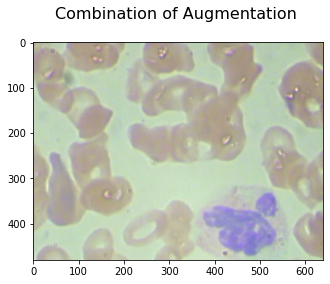

In [132]:
im_aug= augpanel(image=np.array(im))
plt.imshow(Image.fromarray(im_aug))
plt.title('Combination of Augmentation \n', size=16)
plt.show()

## Bounding box adjustment in augmenataion
As discussed, some of the technique (e.g. rotation , flip) can change the location of the objects. Therefore, bounding box calculation also needs to be adjusted as per augmentation.  
This section we derive techniques that allow to retain / adopt bounding box as per augmentation.

### Investigate bounding box augmentation with single image

In [179]:
one_img = BCCDdf.loc[BCCDdf['ID']==363]

In [180]:
one_imglist = one_img.values.tolist()

In [181]:
one_imglist[0][1].split('/')[-1]

'BloodImage_363.jpg'

In [182]:
im0= Image.open('/content/YOLO/Training/Images/BloodImage_363.jpg')
# Image to array
im0= np.array(im0)
# Collect boun ding box co-ordinates
bbs = BoundingBoxesOnImage([ia.BoundingBox(x1=e[-4], y1=e[-2], x2=e[-3],y2=e[-1],label=e[-5]) for e in one_imglist], shape=im0.shape)

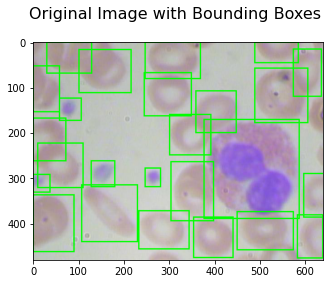

In [183]:
plt.imshow(bbs.draw_on_image(im0, size=3))
plt.title('Original Image with Bounding Boxes \n', size=16)
plt.show()

In [170]:
# Perform image augmentation and bounding box recalculation
img_aug, bbs_aug= augpanel(image=im0, bounding_boxes=bbs)

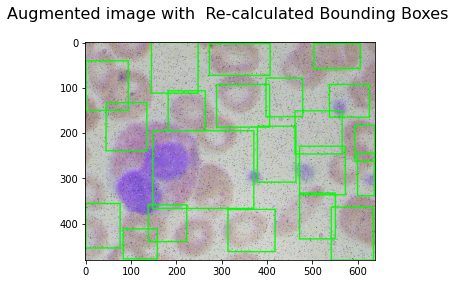

In [171]:
plt.imshow(bbs_aug.draw_on_image(img_aug, size=3))
plt.title('Augmented image with  Re-calculated Bounding Boxes \n', size=16)
plt.show()

### Generate augmented images and bounding boxes
Set 1

In [195]:
imgid = list(set(list(BCCDdf['ID'])))

In [196]:
alldata = []
ia.seed(1990)
for id in imgid:
  one_img= BCCDdf.loc[BCCDdf['ID']==id]
  one_imglist = one_img.values.tolist()
  im0= Image.open(os.path.join('/content/YOLO/Training/Images',one_imglist[0][1].split('/')[-1]))
  im0= np.array(im0)
  bbs = BoundingBoxesOnImage([ia.BoundingBox(x1=e[-4], y1=e[-2], x2=e[-3],y2=e[-1],label=e[-5]) for e in one_imglist], shape=im0.shape)
  img_aug, bbs_aug= augpanel(image=im0, bounding_boxes=bbs)
  io.imwrite(os.path.join('/content/YOLO/Training/Aug1/Images',one_imglist[0][1].split('/')[-1]),img_aug)
  for k in range(len(one_imglist)):
    x1= bbs_aug.bounding_boxes[k].x1
    x2= bbs_aug.bounding_boxes[k].x2
    y1= bbs_aug.bounding_boxes[k].y1
    y2= bbs_aug.bounding_boxes[k].y2
    lbl = bbs_aug.bounding_boxes[k].label
    imgpath= one_imglist[0][1].replace('Annotations', 'JPEGImages')
    ID= id
    row=[ID, imgpath, lbl, x1, y1, x2, y2]
    alldata.append(row)

In [198]:
names = ['ID','filename','cell_type','xmin','ymin','xmax','ymax']
augdf = pd.DataFrame(alldata, columns=names)
augdf.to_csv('/content/YOLO/Training/Aug1/annotations.csv')

Set 2  

Different seed will generate different augmentation

In [200]:
alldata = []
ia.seed(2022)
for id in imgid:
  one_img= BCCDdf.loc[BCCDdf['ID']==id]
  one_imglist = one_img.values.tolist()
  im0= Image.open(os.path.join('/content/YOLO/Training/Images',one_imglist[0][1].split('/')[-1]))
  im0= np.array(im0)
  bbs = BoundingBoxesOnImage([ia.BoundingBox(x1=e[-4], y1=e[-2], x2=e[-3],y2=e[-1],label=e[-5]) for e in one_imglist], shape=im0.shape)
  img_aug, bbs_aug= augpanel(image=im0, bounding_boxes=bbs)
  io.imwrite(os.path.join('/content/YOLO/Training/Aug2/Images',one_imglist[0][1].split('/')[-1]),img_aug)
  for k in range(len(one_imglist)):
    x1= bbs_aug.bounding_boxes[k].x1
    x2= bbs_aug.bounding_boxes[k].x2
    y1= bbs_aug.bounding_boxes[k].y1
    y2= bbs_aug.bounding_boxes[k].y2
    lbl = bbs_aug.bounding_boxes[k].label
    imgpath= one_imglist[0][1].replace('Annotations', 'JPEGImages')
    ID= id
    row=[ID, imgpath, lbl, x1, y1, x2, y2]
    alldata.append(row)

In [201]:
names = ['ID','filename','cell_type','xmin','ymin','xmax','ymax']
augdf = pd.DataFrame(alldata, columns=names)
augdf.to_csv('/content/YOLO/Training/Aug2/annotations.csv')

In [203]:
# zip all data and download
!zip -r /content/YOLO.zip /content/YOLO

files.download('/content/YOLO.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>